Last edit: 2024-06-27
# Example notebook - How to use *parrot*🦜 in a jupyter notebook
You can see various steps how *parrot* can be used to read-in continous recorded data (contained in the folder `example_data`), how it can be processed and plotted.

In [1]:
import parrot

# To read-in the the raw data
import h5py

# To make intermedia plots
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

Our example files are stored in the efficient binary format HDF-5, which can be read-in by Python, Matlab and other programs.
If you want to learn more about this data format, check-out this YouTube-Tutorial series:
https://www.youtube.com/watch?v=S74Kc8QYDac&list=PLPyhR4PdEeGYWHRhzmCP5stzfIha8bqVg

But for here, this is not necessary, since we just read the files in:

we use the `with` statement to gracefully open/close the file and read three datasets `time`, `position` , and `signal`.
It is important to have the square brackets with the colon to not only have a view on the data (which is gone when the file is close) but fully read-in the array.

In [2]:
with h5py.File(r"parrot/example_data/light.h5", "r") as f:
    time = f["time"][:]
    position = f["position"][:]
    signal = f["signal"][:]
    light = {"time": time, "position": position, "signal": signal}

In the last line, a Python dictionary is created with three keys and three corresponding numpy array containg the values.

In [3]:
light

{'time': array([0.000000e+00, 2.000000e-05, 4.000000e-05, ..., 5.999994e+01,
        5.999996e+01, 5.999998e+01]),
 'position': array([7.737579 , 7.740137 , 7.743045 , ..., 2.5423698, 2.5518126,
        2.5612166], dtype=float32),
 'signal': array([0.00156629, 0.00155461, 0.00152874, ..., 0.00093013, 0.00069338,
        0.00048971], dtype=float32)}

Let us take a closer look on the data and plot the postion vs. time and the signal vs. time:

In [4]:
%matplotlib inline

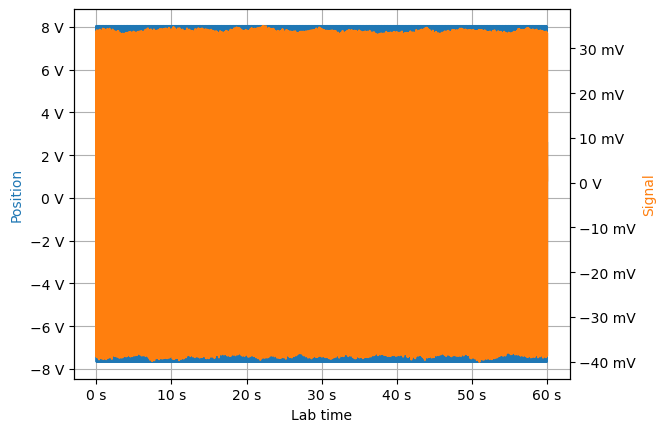

In [5]:
fig, ax = plt.subplots()
ax.plot(light["time"], light["position"], color="tab:blue")
ax.grid(True)
ax.xaxis.set_major_formatter(EngFormatter("s"))
ax.yaxis.set_major_formatter(EngFormatter("V"))
ax.set_ylabel("Position", color="tab:blue")
ax.set_xlabel("Lab time")

ax2 = ax.twinx()
ax2.plot(light["time"], light["signal"], color="tab:orange")
ax2.yaxis.set_major_formatter(EngFormatter("V"))
ax2.set_ylabel("Signal", color="tab:orange")
plt.show(block=False)

We see that we have a 60 s measurement, but besides this is the data density too high. Let us zoom-in a bit more to see single THz traces:

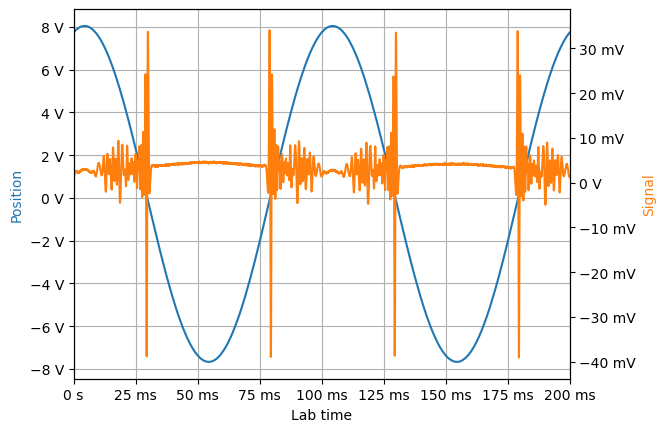

In [6]:
fig, ax = plt.subplots()
ax.plot(light["time"], light["position"], color="tab:blue")
ax.grid(True)
ax.xaxis.set_major_formatter(EngFormatter("s"))
ax.yaxis.set_major_formatter(EngFormatter("V"))
ax.set_ylabel("Position", color="tab:blue")
ax.set_xlabel("Lab time")

ax2 = ax.twinx()
ax2.plot(light["time"], light["signal"], color="tab:orange")
ax2.yaxis.set_major_formatter(EngFormatter("V"))
ax2.set_ylabel("Signal", color="tab:orange")

ax.set_xlim([0,0.2])
plt.show(block=False)

We can detect the sinusoidal moving pattern (blue) of the oscillating delay line. It needs 100 ms for one period, meaning the shaker was running at 10 Hz. Since we see a THz trace when the moving is forward as well as when the shaker is moving backward, we get double the amount of traces, thus 20 THz traces / s.
As expected, the signal is mirrored when the shaker moves backward. Additionally, there is some "bending" of the baseline of the THz trace, which is repeatable. These systematic error *parrot* can compensate.

This systematic error correction works best, when two dark measurements are supplied alongside the light measurement. A dark measurement has all the same recording settings, just the THz beam is blocked. This measures the noise floor and one can not only assess the system performance, but it also helps to correct systematic errors.

Let us load-in two more dark datasets to see the full capability of *parrot*.

In [7]:
with h5py.File(r"parrot/example_data/dark1.h5", "r") as f:
    time = f["time"][:]
    position = f["position"][:]
    signal = f["signal"][:]
    dark1 = {"time": time, "position": position, "signal": signal}

with h5py.File(r"parrot/example_data/dark2.h5", "r") as f:
    time = f["time"][:]
    position = f["position"][:]
    signal = f["signal"][:]
    dark2 = {"time": time, "position": position, "signal": signal}

Since we alredy read-in our data, we don't need the `Load`-class of *parrot*. Instead, we can directly create a `process_obj`, derived from the `Process`-class of *parrot*.

There are multiple methods available to the user, depending on which dataset is available:
1. `thz_and_two_darks`
2. `thz_and_dark`
4. `thz_only`
5. `dark_only`

In [8]:
process_obj = parrot.Process()

The only missing information is the conversion between the voltage recorded for the position channel and the corresponding delay in light time.
A `scale`-factor needs to be supplied to facilitate [V] -> [s]. THe oscillating delay linse used for this example data is the [APE scanDelay 50 ps](https://www.ape-berlin.de/en/optical-delay/#1500043794885-e05f0280-1597).

It has a calibrated voltage output of +-10 V (20 V peak-peak) for a corresponding delay of 50 ps.

In [9]:
scale = 50e-12 / 20

The last setting to discuss is the `debug`-parameter. At various positions inside *parrot* a message with various priorities (`DEBUG`, `INFO`, and `WARNING`) is passes to an internal logger. When the parameter is not speficied, only log-messages of the kind `WARNING` will be passed to the user. When selecting `debug=True`, log-messages of the kind `INFO` and higher will be displayed.

Parrot will first analyze the light dataset, where the THz data from the forward/backward movement of the delay stage is processed. 
A delay on the positional data will be adjusted, so that the single traces overlap and the standard deviation of all traces is minimized.

[INFO] parrot.process.prepare_data: Position data is low-pass filtered with 100 Hz.
[INFO] parrot.process.prepare_data: 50 THz > Nyquist-frequency (25 kHz), ignoring parameter.
[INFO] parrot.process.prepare_data: Signal data is low- and high-pass filtered with [1 Hz, 50 THz].
[INFO] parrot.process.prepare_data: Found interpolation resolution to have more than 50.0 THz: 2 ** 12 = 4096 points
[INFO] parrot.process.prepare_data: No delay_value provided, searching now for optimal delay:
[INFO] parrot.process.prepare_data: Delay:	0.000	Error:	27.634530855365675
[INFO] parrot.process.prepare_data: Delay:	10.000	Error:	113.68047403871554
[INFO] parrot.process.prepare_data: Delay:	-10.000	Error:	100.09860209303974
[INFO] parrot.process.prepare_data: Delay:	-5.000	Error:	51.87617682188713
[INFO] parrot.process.prepare_data: Delay:	5.000	Error:	85.05565233594749
[INFO] parrot.process.prepare_data: Delay:	-2.500	Error:	20.49652690457985
[INFO] parrot.process.prepare_data: Delay:	-5.000	Error:	51.

Optimization terminated successfully.
         Current function value: 11.148248
         Iterations: 14
         Function evaluations: 28


[INFO] parrot.process.prepare_data: Found interpolation resolution to have more than 50.0 THz: 2 ** 12 = 4096 points
[INFO] parrot.process.prepare_data: Position data is low-pass filtered with 100 Hz.
[INFO] parrot.process.prepare_data: 50 THz > Nyquist-frequency (25 kHz), ignoring parameter.
[INFO] parrot.process.prepare_data: Signal data is low- and high-pass filtered with [1 Hz, 50 THz].
[INFO] parrot.process.prepare_data: Found interpolation resolution to have more than 50.0 THz: 2 ** 12 = 4096 points
[INFO] parrot.process.cut_data: Creating matrix with (4096, 1199). Starting interpolation for all traces...
[INFO] parrot.process.cut_data: Creating matrix with (4096, 1202). Starting interpolation for all traces...
[INFO] parrot.process.cut_data: Creating matrix with (4096, 1213). Starting interpolation for all traces...


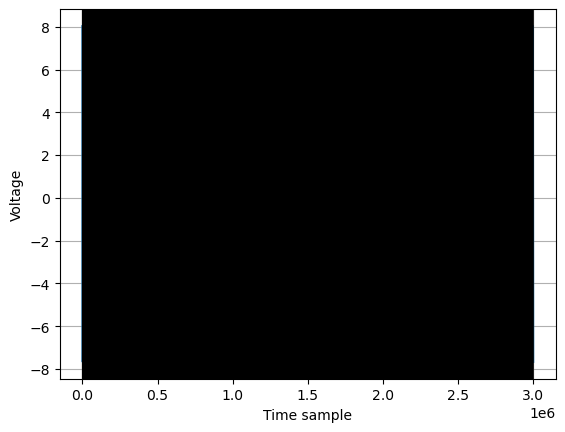

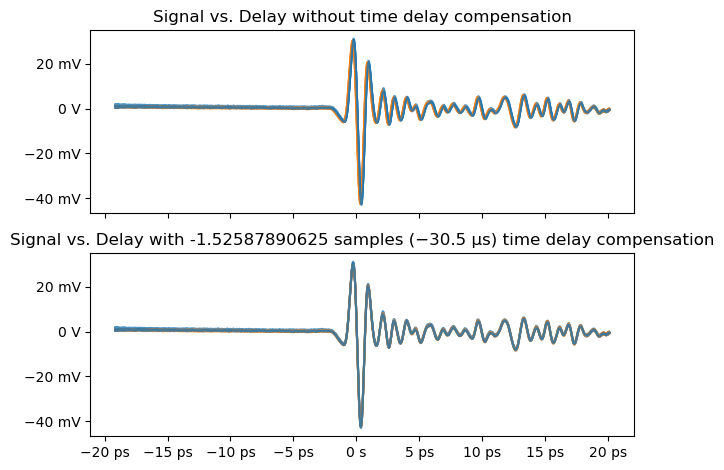

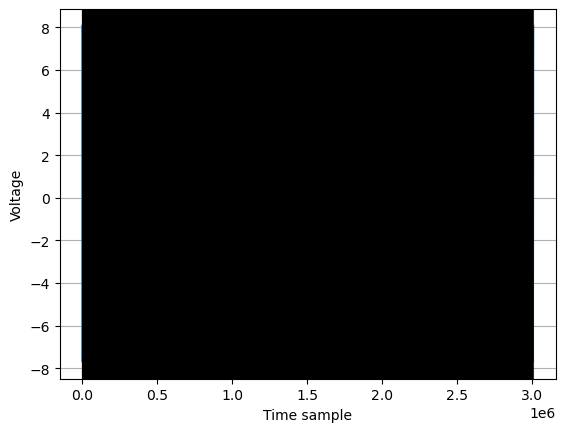

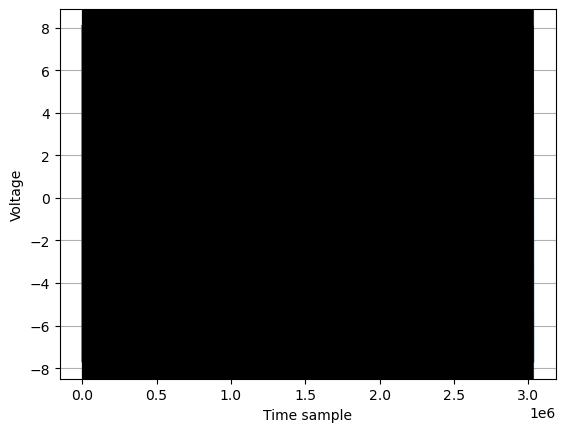

In [10]:
data = process_obj.thz_and_two_darks(light, dark1, dark2, scale=scale, debug=True)

Afterwards, the `data` dictionary contains three keys:

In [11]:
data.keys()

dict_keys(['light', 'dark1', 'dark2'])

Taking a closer look to the values of one of the keys, shows a pleathora of information. The most important one are `light_time`, `single_traces` and `average`. The first one is a 1-D numpy array, the second element is a 2-D numpy array, consisting of the interpolated sampling number times the number of single traces extracted from the continuous measurement. The last one, `average` is another python dictionary.

In [12]:
data["light"].keys()

dict_keys(['scale', 'delay_value', 'position', 'signal', 'number_of_traces', 'interpolation_resolution', 'trace_cut_index', 'thz_recording_length', 'thz_start_offset', 'interpolated_position', 'light_time', 'single_traces', 'average'])

Here we only have at the moment the average in `time_domain`:

In [13]:
data["light"]["average"].keys()

dict_keys(['time_domain'])

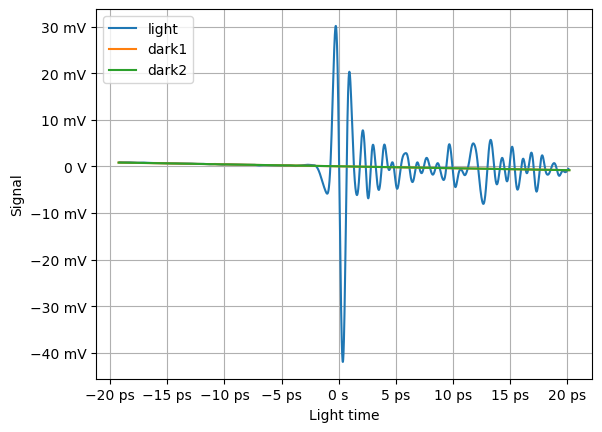

In [16]:
fig, ax = plt.subplots()
for mode in data.keys():
    ax.plot(data[mode]["light_time"], data[mode]["average"]["time_domain"], label=mode)
ax.grid(True)
ax.xaxis.set_major_formatter(EngFormatter("s"))
ax.yaxis.set_major_formatter(EngFormatter("V"))
ax.set_ylabel("Signal")
ax.set_xlabel("Light time")
ax.legend(loc="upper left")
plt.show(block=False)

When using the `Plot`-class of *parrot*, we receive an **error**:

NotImplementedError: You supplied two dark measurements but did not execute `correct_systematic_errors()` of the `Process`-class yet.

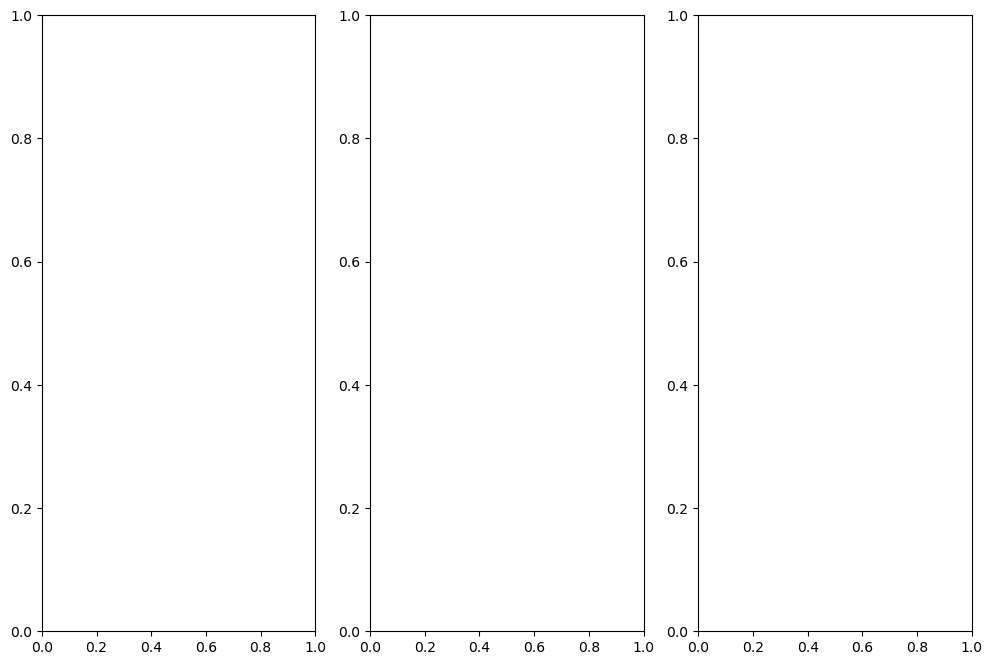

In [17]:
plot_obj = parrot.Plot()
plot_obj.plot_simple_multi_cycle(data)
plt.show(block=False)

*parrot* makes us aware, that we have supplied two dark measurements but did not apply the systematic error correction from the `PostProcessData`-class to our data. 

## Let us fix this problem:

In [18]:
post_obj = parrot.PostProcessData(data)
data = post_obj.correct_systematic_errors()

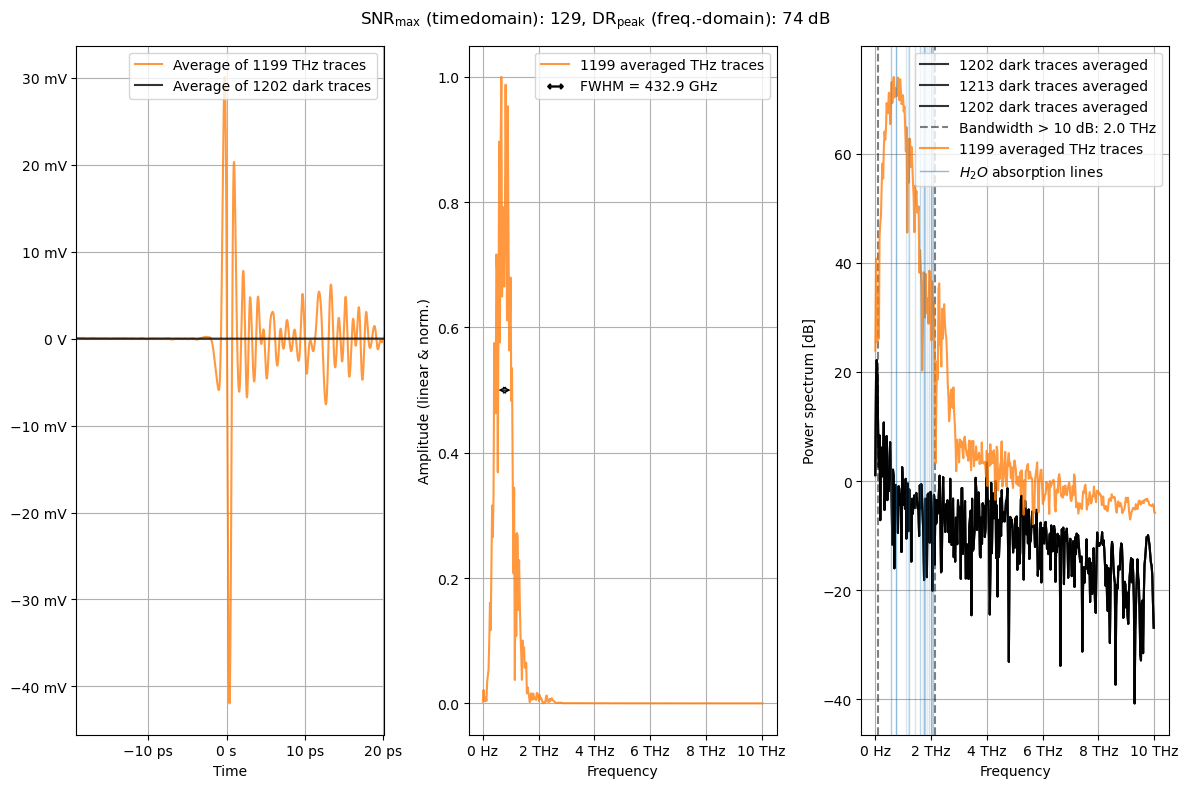

In [19]:
plot_obj = parrot.Plot()
plot_obj.plot_simple_multi_cycle(data)
plt.show(block=False)

The three subplots show the time domain and two times the frequency domain, once the amplitude on a normalized linear scale and once the power spectrum on a logarithmic scale in dB. We observe multiple problems and *parrot* is warning us, that we didn't treat the data, yet. 

The time domain shows some position dependent drop in ampliutude, which is observeable in the light and the dark data. We did not apply a window to the data yet, which explains the slight offset between THz data and dark data on the logarithmic axis.

Let us fix this problem, too:

In [20]:
data = post_obj.super_gaussian(window_width=0.6)

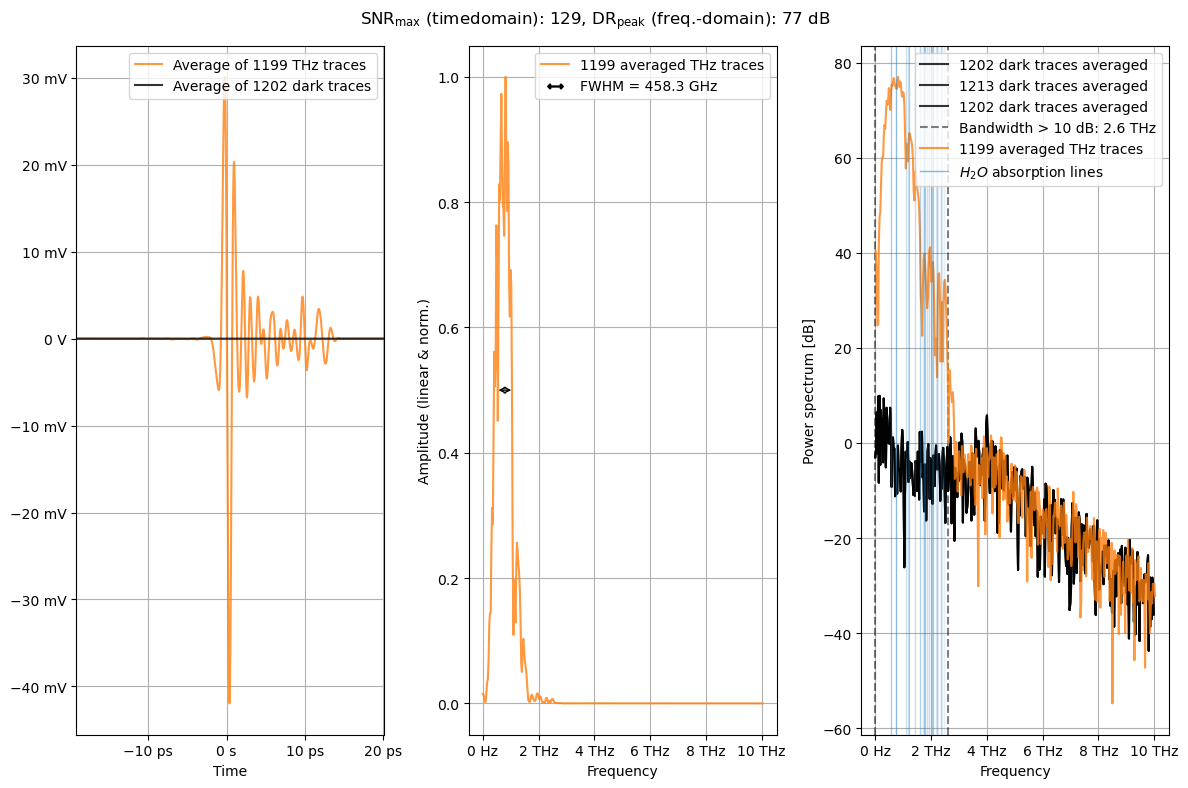

In [21]:
plot_obj = parrot.Plot()
plot_obj.plot_simple_multi_cycle(data)
plt.show(block=False)